In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# Network Parameters
num_input = 6
timesteps = 50 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [4]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
        for t in range(start_time-1, end_time):
            window_y[t] = [0.5]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [5]:
step_data_list = []
for i in range(1,6):
    step_data_list.append([i, 11, '1L', 'NA'])
    step_data_list.append([i, 12, '1L', 'NA'])
    step_data_list.append([i, 13, '1L', 'NA'])
    step_data_list.append([i, 14, '1L', 'NA'])
    step_data_list.append([i, 15, '1L', 'NA'])
    step_data_list.append([i, 11, '2R', 'NA'])
    step_data_list.append([i, 12, '2R', 'NA'])
    step_data_list.append([i, 13, '2R', 'NA'])
    step_data_list.append([i, 14, '2R', 'NA'])
    step_data_list.append([i, 15, '2R', 'NA'])    
    
print(step_data_list)

[[1, 11, '1L', 'NA'], [1, 12, '1L', 'NA'], [1, 13, '1L', 'NA'], [1, 14, '1L', 'NA'], [1, 15, '1L', 'NA'], [1, 11, '2R', 'NA'], [1, 12, '2R', 'NA'], [1, 13, '2R', 'NA'], [1, 14, '2R', 'NA'], [1, 15, '2R', 'NA'], [2, 11, '1L', 'NA'], [2, 12, '1L', 'NA'], [2, 13, '1L', 'NA'], [2, 14, '1L', 'NA'], [2, 15, '1L', 'NA'], [2, 11, '2R', 'NA'], [2, 12, '2R', 'NA'], [2, 13, '2R', 'NA'], [2, 14, '2R', 'NA'], [2, 15, '2R', 'NA'], [3, 11, '1L', 'NA'], [3, 12, '1L', 'NA'], [3, 13, '1L', 'NA'], [3, 14, '1L', 'NA'], [3, 15, '1L', 'NA'], [3, 11, '2R', 'NA'], [3, 12, '2R', 'NA'], [3, 13, '2R', 'NA'], [3, 14, '2R', 'NA'], [3, 15, '2R', 'NA'], [4, 11, '1L', 'NA'], [4, 12, '1L', 'NA'], [4, 13, '1L', 'NA'], [4, 14, '1L', 'NA'], [4, 15, '1L', 'NA'], [4, 11, '2R', 'NA'], [4, 12, '2R', 'NA'], [4, 13, '2R', 'NA'], [4, 14, '2R', 'NA'], [4, 15, '2R', 'NA'], [5, 11, '1L', 'NA'], [5, 12, '1L', 'NA'], [5, 13, '1L', 'NA'], [5, 14, '1L', 'NA'], [5, 15, '1L', 'NA'], [5, 11, '2R', 'NA'], [5, 12, '2R', 'NA'], [5, 13, '2R'

In [6]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    for dx in data_x_segement:
        data_x.extend(dx)
    for dy in data_y_segement:
        data_y.extend(dy)
    
print(len(data_x))
print(len(data_y))

107457
107457


In [7]:
data_size = len(data_x)
batch_size = 256
print(data_size)

order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x_list, train_y_list = [], []
valid_x_list, valid_y_list = [], []

#10 fold cross validation
for i in range(0,10):
    start = int(data_size*1.0/10*i)
    end = int(data_size*1.0/10*(i+1))
    print(start, end)
    
    train_x = [data_x[i] for i in order[0:start]]
    train_x.extend([data_x[i] for i in order[end:data_size]])
    train_x.extend([train_x[i] for i in range(0, batch_size)])
    train_y = [data_y[i] for i in order[0:start]]
    train_y.extend([data_y[i] for i in order[end:data_size]])
    train_y.extend([train_y[i] for i in range(0, batch_size)])
    train_x_list.append(train_x)
    train_y_list.append(train_y)
    
    valid_x = [data_x[i] for i in order[start:end]]
    valid_x.extend([valid_x[i] for i in range(0, batch_size)])
    valid_y = [data_y[i] for i in order[start:end]]
    valid_y.extend([valid_y[i] for i in range(0, batch_size)])
    valid_x_list.append(valid_x)
    valid_y_list.append(valid_y)
    
    print(len(train_x), len(valid_x))

107457
0 10745
96968 11001
10745 21491
96967 11002
21491 32237
96967 11002
32237 42982
96968 11001
42982 53728
96967 11002
53728 64474
96967 11002
64474 75219
96968 11001
75219 85965
96967 11002
85965 96711
96967 11002
96711 107457
96967 11002


In [8]:
step_test_list = []
for i in range(6,7):
    step_test_list.append([i, 11, '1L', 'NA'])
    step_test_list.append([i, 12, '1L', 'NA'])
    step_test_list.append([i, 13, '1L', 'NA'])
    step_test_list.append([i, 14, '1L', 'NA'])
    step_test_list.append([i, 15, '1L', 'NA'])
    step_test_list.append([i, 11, '2R', 'NA'])
    step_test_list.append([i, 12, '2R', 'NA'])
    step_test_list.append([i, 13, '2R', 'NA'])
    step_test_list.append([i, 14, '2R', 'NA'])
    step_test_list.append([i, 15, '2R', 'NA'])    
        
print(step_test_list)

[[6, 11, '1L', 'NA'], [6, 12, '1L', 'NA'], [6, 13, '1L', 'NA'], [6, 14, '1L', 'NA'], [6, 15, '1L', 'NA'], [6, 11, '2R', 'NA'], [6, 12, '2R', 'NA'], [6, 13, '2R', 'NA'], [6, 14, '2R', 'NA'], [6, 15, '2R', 'NA']]


In [9]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

38
38
[10, 366, 5, 1035, 51, 424, 884, 25, 172, 177, 59, 643, 686, 598, 1184, 821, 604, 1141, 774, 10, 366, 5, 1035, 51, 424, 884, 25, 172, 177, 59, 643, 686, 598, 1184, 821, 604, 1141, 774]


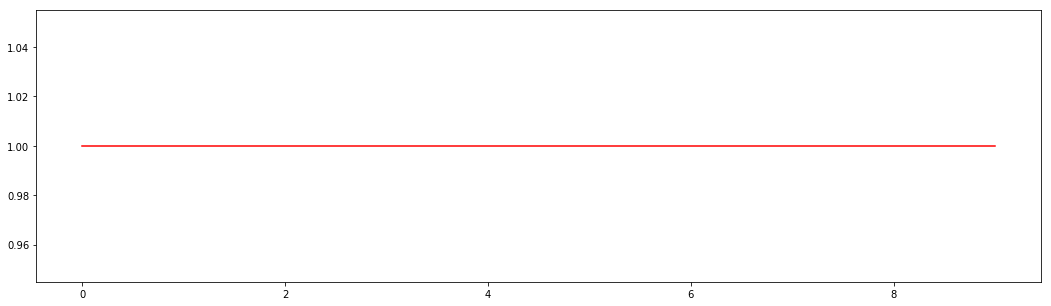

In [10]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[0]], 'r')
plt.show()

In [11]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

#         return tf.matmul(outputs[-2], weights['out']) + biases['out']
        ret = []
#         print(outputs.shape)
        for i in range(0, timesteps):
            ret.append(tf.matmul(outputs[i], weights['out']) + biases['out'])
            
        return ret

#         return np.array(ret)
    
    logits = RNN(X, weights, biases)
    logits = tf.transpose(logits, [1,0,2])
#     print(len(logits))
    print(logits.shape)
    print(logits[0].shape)
    mean_train = tf.reduce_mean(X)
    
    
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

(?, 50, 1)
(50, 1)


In [12]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

96967
96967


In [13]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

97223


In [18]:
def cal_accuarcy(y, _y):
#     print(len(y))
#     print(len(y[0]))
#     print(len(y[0][0]))
#     print(y[0][0])
    count = 0
    total = 0
    for i in range(len(y[0])):
        total += 1
        if(y[0][i][0] == round(_y[0][i][0])):
            count += 1
    for i in range(1, len(y)):
        total += 1
        if(y[i][-1][0] == round(_y[i][-1][0])):
            count += 1;
    return(count*1.0/total)
#     print("train accuarcy : ", count/len(y))

In [37]:
training_steps = 4001
test_loss_list, test_logits_list = [], []

for i in range(0, 10):
    batch_start=0
    print("cross validation ", i)
    batch_start = 0
    train_x = train_x_list[i]
    train_y = train_y_list[i]
    config = tf.ConfigProto(allow_soft_placement=True)
    with tf.Session(graph=graph, config=config) as session:
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
    #     saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2.ckpt-6000")
        tf.global_variables_initializer().run()
        print('Initialized')
        for step in range(training_steps):      
            feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
            _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
            if (step % 200 == 0):
                train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
                print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
                #train accuarcy
            if (step % 1000 == 0):
                saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-na-10fold-'+str(i)+'-.ckpt', global_step=step+6000)
            batch_start += batch_size
            if(batch_start>=train_length):
                batch_start -=train_length
        valid_loss, valid_logits = session.run([loss,logits], feed_dict={X: valid_x_list[i], Y: valid_y_list[i]})
        print("test loss : ", valid_loss)
        cal_accuarcy(valid_y_list[i], valid_logits)

        test_loss, test_logits = [], []
        for i in range(len(test_x)):
            test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
            test_loss.append(test_loss_part)
            test_logits.append(test_logits_part)

        test_loss_list.append(test_loss)
        test_logits_list.append(test_logits)


cross validation  0
Initialized
Loss at step 0: 0.479793, train accuarcy : 0.534426
Loss at step 200: 0.116594, train accuarcy : 0.911475
Loss at step 400: 0.096594, train accuarcy : 0.924590
Loss at step 600: 0.086471, train accuarcy : 0.934426
Loss at step 800: 0.077767, train accuarcy : 0.927869
Loss at step 1000: 0.069983, train accuarcy : 0.904918
Loss at step 1200: 0.066287, train accuarcy : 0.947541
Loss at step 1400: 0.069436, train accuarcy : 0.918033
Loss at step 1600: 0.066364, train accuarcy : 0.937705
Loss at step 1800: 0.065762, train accuarcy : 0.940984
Loss at step 2000: 0.061909, train accuarcy : 0.937705
Loss at step 2200: 0.060322, train accuarcy : 0.960656
Loss at step 2400: 0.062405, train accuarcy : 0.954098
Loss at step 2600: 0.054920, train accuarcy : 0.947541
Loss at step 2800: 0.057804, train accuarcy : 0.944262
Loss at step 3000: 0.052859, train accuarcy : 0.950820
Loss at step 3200: 0.056208, train accuarcy : 0.940984
Loss at step 3400: 0.053058, train accua

Loss at step 3600: 0.052435, train accuarcy : 0.947541
Loss at step 3800: 0.051205, train accuarcy : 0.947541
Loss at step 4000: 0.055730, train accuarcy : 0.944262
test loss :  0.0525455
cross validation  7
Initialized
Loss at step 0: 1.181039, train accuarcy : 0.281967
Loss at step 200: 0.143487, train accuarcy : 0.885246
Loss at step 400: 0.120273, train accuarcy : 0.895082
Loss at step 600: 0.101128, train accuarcy : 0.921311
Loss at step 800: 0.095372, train accuarcy : 0.895082
Loss at step 1000: 0.081631, train accuarcy : 0.931148
Loss at step 1200: 0.076413, train accuarcy : 0.931148
Loss at step 1400: 0.075635, train accuarcy : 0.934426
Loss at step 1600: 0.070625, train accuarcy : 0.934426
Loss at step 1800: 0.065592, train accuarcy : 0.944262
Loss at step 2000: 0.065531, train accuarcy : 0.970492
Loss at step 2200: 0.065263, train accuarcy : 0.940984
Loss at step 2400: 0.062464, train accuarcy : 0.954098
Loss at step 2600: 0.060828, train accuarcy : 0.944262
Loss at step 2800

In [32]:
# with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-na-10fold-9-.ckpt-7000")
#     print('Test')

#     test_loss, test_logits = [], []
#     for i in range(len(test_x)):
#         test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
#         test_loss.append(test_loss_part)
#         test_logits.append(test_logits_part)

INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric-dropout2-na-10fold-9-.ckpt-7000
Test


38
38


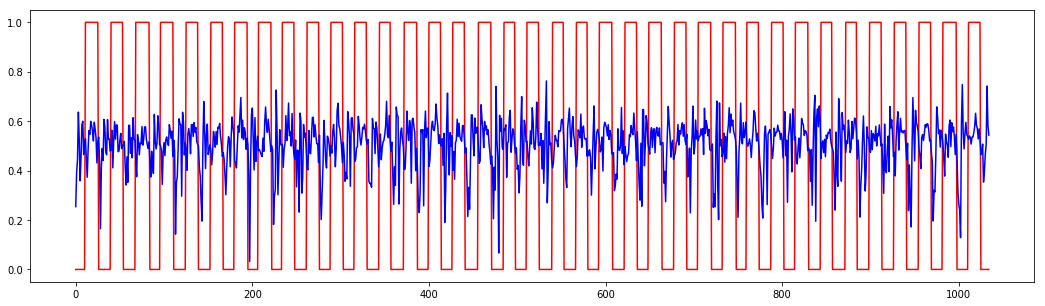

In [169]:
print(len(test_y))
print(len(test_logits_list[0]))

index = 9
index1= 3

test_logits = test_logits_list[index]


plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[0] for i in test_y[index1][start:end]], 'r')
plt.plot([i[0] for i in test_logits[index1][start:end]], 'b')
plt.show()

In [170]:
print("test loss : ", test_loss)

test loss :  [0.08516591, 0.075543262, 0.1064271, 0.093846202, 0.051693629, 0.10678257, 0.14159057, 0.10143266, 0.094509691, 0.096280873, 0.044872627, 0.091366351, 0.084036961, 0.074498653, 0.086424053, 0.079374418, 0.084856212, 0.087738499, 0.10582647, 0.080982238, 0.053376291, 0.035644479, 0.058382709, 0.082859054, 0.092851341, 0.098192185, 0.091668211, 0.10365361, 0.10578998, 0.055808939, 0.10514129, 0.10046888, 0.08562012, 0.12001052, 0.07273449, 0.082378238, 0.07720647, 0.099157676]


In [171]:
print(len(test_logits))
print(len(test_logits[0]))
print(len(test_logits[0][0]))  

test_y_seq_list, test_logits_bin_list = [], []

for t in test_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    test_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin_list.append(test_logits_part)
    
for t in test_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    test_y_seq_list.append(t_all)

# print(test_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(test_y_seq_list)):
    total += len(test_y_seq_list[i])
    for j in range(0, len(test_y_seq_list[i])):
        if(test_y_seq_list[i][j][0] == test_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

38
10
50
18927
21180
test accuarcy :  0.8936260623229462


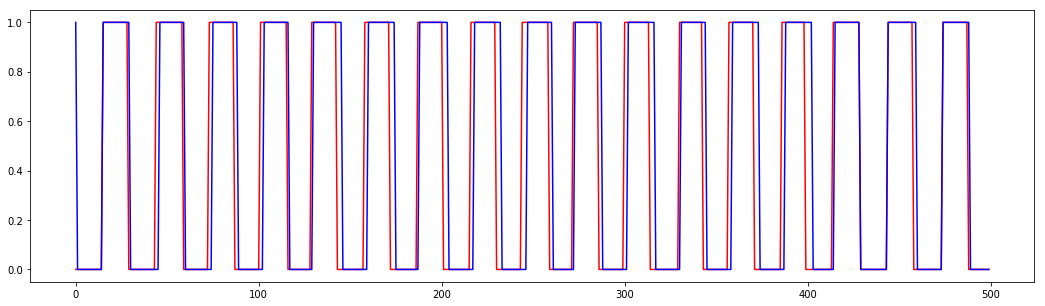

In [172]:
ii = 13

start=0
end=500

plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y_seq_list[ii][start:end]], 'r')
plt.plot([i[0] for i in test_logits_bin_list[ii][start:end]], 'b')
plt.show()

In [173]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#test_y_seq_list, test_logits_bin_list
for i in range(0, len(test_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(test_y_seq_list[i])):
        if(abs(test_y_seq_list[i][j][0]-test_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin_list[i][j][0]-test_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
print(step_time_actual[iii])
print(step_time_actual_gap[iii])
print(step_time_predict[iii])

Step number for each segement
[4, 30, 3, 77, 6, 34, 67, 5, 15, 15, 7, 46, 49, 44, 86, 60, 43, 82, 58, 4, 30, 3, 77, 6, 34, 67, 5, 15, 15, 7, 46, 49, 44, 86, 60, 43, 82, 58]
[4, 30, 4, 78, 6, 36, 74, 6, 15, 14, 6, 46, 49, 45, 86, 60, 44, 82, 57, 6, 29, 4, 78, 6, 33, 66, 5, 14, 14, 6, 47, 49, 45, 86, 62, 42, 82, 58]
[15, 29, 44, 59, 73, 87, 101, 116, 129, 143, 158, 172, 187, 201, 216, 230, 244, 259, 272, 286, 300, 314, 330, 343, 357, 371, 386, 399, 414, 429, 444, 458, 474, 488, 503, 517, 533, 547, 563, 575, 591, 605, 620, 634]
[0, 22.0, 36.5, 51.5, 66.0, 80.0, 94.0, 108.5, 122.5, 136.0, 150.5, 165.0, 179.5, 194.0, 208.5, 223.0, 237.0, 251.5, 265.5, 279.0, 293.0, 307.0, 322.0, 336.5, 350.0, 364.0, 378.5, 392.5, 406.5, 421.5, 436.5, 451.0, 466.0, 481.0, 495.5, 510.0, 525.0, 540.0, 555.0, 569.0, 583.0, 598.0, 612.5, 627.0, 1268]
[1, 15, 30, 46, 60, 75, 89, 103, 117, 130, 146, 160, 175, 188, 204, 218, 233, 247, 261, 273, 288, 302, 317, 331, 345, 359, 374, 388, 403, 415, 429, 444, 460, 474, 4

In [174]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(test_x))

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

38
38
26
[0, 0, 1, 1, 0, 2, 9, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0]
38
22
[0, 0, 1, 1, 0, 2, 7, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0]
error : 
total undercount metric 1:	 0.22093023255813954
total overcount metric 1:	 0.21477428180574556
total undercount metric 2:	 0.009575923392612859
total overcount metric 2:	 0.017783857729138167
total undercount metric 3:	 0.006839945280437756
total overcount metric 3:	 0.015047879616963064


# index = 1
total undercount metric 1 :  0.22154471544715448
total overcount metric 1 :  0.2073170731707317
total undercount metric 2 :  0.016260162601626018
total overcount metric 2 :  0.007452574525745257
total undercount metric 3 :  0.011517615176151762
total overcount metric 3 :  0.013550135501355014
# index=2
total undercount metric 1 :  0.22831978319783197
total overcount metric 1 :  0.21747967479674796
total undercount metric 2 :  0.014905149051490514
total overcount metric 2 :  0.008807588075880758
total undercount metric 3 :  0.008807588075880758
total overcount metric 3 :  0.014227642276422764
# index=3
total undercount metric 1 :  0.19986449864498645
total overcount metric 1 :  0.18834688346883469
total undercount metric 2 :  0.014905149051490514
total overcount metric 2 :  0.008807588075880758
total undercount metric 3 :  0.008807588075880758
total overcount metric 3 :  0.01016260162601626
# index=4
total undercount metric 1 :  0.22560975609756098
total overcount metric 1 :  0.21544715447154472
total undercount metric 2 :  0.014905149051490514
total overcount metric 2 :  0.008130081300813009
total undercount metric 3 :  0.009485094850948509
total overcount metric 3 :  0.01084010840108401
